### A/B Test on E-commerce Free Shipping Bar 
#### We would like to test if adding free shipping banner will facilitate user conversion.


##### 1) Extract data from the database 

In [9]:
##import Packages

import pandas as pd
import numpy as np
import math
import scipy.stats
from matplotlib import pyplot as plt
from datetime import date 

In [10]:
## import data

df_Test_Overall = pd.read_csv(r'/Users/elenaln/Desktop/PJ_ABTesting/RawData/VisitDataTest1_2.csv')
df_TestGroupMapping= pd.read_csv(r'/Users/elenaln/Desktop/PJ_ABTesting/RawData/GroupMap.csv')
df_Rev = pd.read_csv(r'/Users/elenaln/Desktop/PJ_ABTesting/RawData/RevData.csv')
df_CategoryMapping = pd.read_csv(r'/Users/elenaln/Desktop/PJ_ABTesting/RawData/CategoryMapping.csv')


In [11]:
df_Test_Overall['testid'].unique()
# There are 2 test in the dataset. 
# testid 1 - Product Description Placement
# testid 2 - Free Shipping Banner

array([2, 1])

In [12]:
df_Test_Overall.columns

Index(['Unnamed: 0', 'testid', 'ControlGroup', 'Date', 'SessionID',
       'ChannelID', 'CategoryID', 'PlatformID', 'CusID', 'VisitorTypeID',
       'Time', 'Bounced', 'SawProduct', 'AddedToCart', 'ReachedCheckout',
       'Converted'],
      dtype='object')

In [13]:
df_Test_Overall.shape
# 13,865,416 rows & 15 attributes

(13865416, 16)

In [14]:
df_Test_Overall['Time'].describe()
#seconds as unit

count    1.386542e+07
mean     1.853080e+03
std      3.672317e+03
min      0.000000e+00
25%      4.900000e+01
50%      3.830000e+02
75%      1.768000e+03
max      3.325610e+05
Name: Time, dtype: float64

##### 2) Clean test2 data and choose a relative stable period for analysis

In [15]:
df_Test2 = df_Test_Overall[df_Test_Overall['testid']==2]
df_Test2.shape

#(6870668, 16)

(6870668, 16)

In [16]:
df_Test2.drop_duplicates (['Date','CusID']).groupby(['Date'])['SessionID'].size()

Date
2019-06-14        64
2019-06-15     47319
2019-06-16     91436
2019-06-17     98786
2019-06-18    123612
2019-06-19    137610
2019-06-20    136537
2019-06-21    142016
2019-06-22    141878
2019-06-23    138622
2019-06-24    129859
2019-06-25    157384
2019-06-26    188860
2019-06-27    176983
2019-06-28    182600
2019-06-29    179240
2019-06-30    166905
2019-07-01    144366
2019-07-02    173548
2019-07-03    213004
2019-07-04    216015
2019-07-05    430902
2019-07-06    254888
2019-07-07    209621
2019-07-08    173080
2019-07-09    198895
2019-07-10    257168
2019-07-11    240236
2019-07-12    123178
Name: SessionID, dtype: int64

In [17]:
# Sanity Check on data 

# 1) How many sessions per day - to see if there are abnormal values in certain days

df_Test2.drop_duplicates (['Date','SessionID']).groupby(['Date'])['SessionID'].size()

# Saw Sessions took several days to ramp up. (2019-06-14 ~ 2019-06-18), 
# therefore we will take the data [2019-06-18 to 2019-07-12]

Date
2019-06-14        69
2019-06-15     59090
2019-06-16    127364
2019-06-17    137998
2019-06-18    173863
2019-06-19    194491
2019-06-20    193602
2019-06-21    200563
2019-06-22    199843
2019-06-23    193444
2019-06-24    180545
2019-06-25    222073
2019-06-26    266630
2019-06-27    248291
2019-06-28    257540
2019-06-29    252746
2019-06-30    233204
2019-07-01    199913
2019-07-02    242003
2019-07-03    298940
2019-07-04    305270
2019-07-05    669742
2019-07-06    363540
2019-07-07    290989
2019-07-08    239339
2019-07-09    275926
2019-07-10    358101
2019-07-11    332720
2019-07-12    152829
Name: SessionID, dtype: int64

In [18]:
# Retrieve the data within our selected timeframe
df_Test2 = df_Test2[pd.to_datetime(df_Test2['Date']) > pd.to_datetime('2019-06-17')]

# Quick Check
df_Test2.groupby(['Date'])['SessionID'].size() 

Date
2019-06-18    173863
2019-06-19    194491
2019-06-20    193602
2019-06-21    200563
2019-06-22    199843
2019-06-23    193444
2019-06-24    180545
2019-06-25    222073
2019-06-26    266630
2019-06-27    248291
2019-06-28    257540
2019-06-29    252746
2019-06-30    233204
2019-07-01    199913
2019-07-02    242003
2019-07-03    298940
2019-07-04    305270
2019-07-05    669742
2019-07-06    363540
2019-07-07    290989
2019-07-08    239339
2019-07-09    275926
2019-07-10    358101
2019-07-11    332720
2019-07-12    152829
Name: SessionID, dtype: int64

In [19]:
import gc
gc.collect()

180

In [132]:
df_Test2= pd.merge(df_Test2, df_CategoryMapping, on=['ChannelID'])

In [190]:
df_Test2.head()

,Unnamed: 0,testid,ControlGroup,Date,SessionID,ChannelID,CategoryID,PlatformID,CusID,VisitorTypeID,Time,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted,Channel Name
0,0,2,1,2019-07-11,7685274065188263037,611,3,1,5299256406894404939,4,434,0,1,0,0,0,Email
1,80,2,1,2019-07-11,1317934814962914954,611,2,1,239259663759935405,2,2128,0,1,1,0,0,Email
2,82,2,0,2019-07-11,1898383736448274575,611,2,1,7598579674028564361,4,202,0,0,0,0,0,Email
3,90,2,1,2019-07-11,995953469126619420,611,5,1,9076630964850975289,3,322,0,1,0,0,0,Email
4,116,2,0,2019-07-11,7268532383450420528,611,5,1,852740141660121970,4,49,1,0,0,0,0,Email


In [191]:
df_Test2_Result = pd.DataFrame(df_Test2.drop_duplicates(['CusID','ControlGroup']).groupby('ControlGroup')['CusID'].count())

In [192]:
df_Test2_Result.head()

,CusID
ControlGroup,
0,871236
1,871160


In [193]:
df_Test2.columns

Index(['Unnamed: 0', 'testid', 'ControlGroup', 'Date', 'SessionID',
       'ChannelID', 'CategoryID', 'PlatformID', 'CusID', 'VisitorTypeID',
       'Time', 'Bounced', 'SawProduct', 'AddedToCart', 'ReachedCheckout',
       'Converted', 'Channel Name'],
      dtype='object')

In [194]:
metrics=['Bounced','SawProduct','AddedToCart','ReachedCheckout','Converted']

for metric in metrics:
    a = df_Test2[df_Test2[metric] == 1].drop_duplicates(['CusID','ControlGroup']).groupby('ControlGroup')['CusID'].count()
    a.name = metric
    df_Test2_Result = df_Test2_Result.join(a)
    

In [195]:
df_Test2_Result

,CusID,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted
ControlGroup,,,,,,
0,871236,317699,821382,678978,393389,317757
1,871160,317587,821177,679029,393159,317198


##### 3) Check significance (Ref: Inference for Proportions)
###### a. Overall Session Level Significance

In [39]:
# Function to find z-score, p-value, percentage lift & absolute lift 

def z_test_calculator(df,denominator, numerator):
    # df: dataframe contraining the result (absolute counts)
    # denominator: str
    # numerator: str
    
    # get the data
    control_denominator = df.loc[1,denominator]
    control_numerator = df.loc[1,numerator]

    
    var_denominator = df.loc[0,denominator]
    var_numerator = df.loc[0,numerator]
    
    ## rate
    control_rate = control_numerator/control_denominator
    var_rate = var_numerator/var_denominator
    
    ##STD
    control_sd = math.sqrt(control_rate*(1-control_rate)/control_denominator)
    var_sd = math.sqrt(var_rate*(1-var_rate)/var_denominator)
    
    ## Z score
    z_score = (control_rate-var_rate)/math.sqrt(pow(control_sd,2) + pow(var_sd,2))
    
    ##p value
    p_value = scipy.stats.norm.sf(abs(z_score))
    
    #lift
    perc_lift = (var_rate-control_rate)/control_rate
    abs_lift = (var_rate -control_rate)
    
    return (p_value, perc_lift, abs_lift)

In [196]:
dic_final={}

In [197]:
unit_diversion = 'CusID'
df_Test2_Result=pd.DataFrame(df_Test2.drop_duplicates([unit_diversion,'ControlGroup']).groupby('ControlGroup')[unit_diversion].count())

metrics=['Bounced','SawProduct','AddedToCart','ReachedCheckout','Converted']
for metric in metrics:
    a = df_Test2[df_Test2[metric]==1].drop_duplicates([unit_diversion,'ControlGroup']).groupby('ControlGroup')[unit_diversion].count()
    a.name = metric
    df_Test2_Result = df_Test2_Result.join(a)

KPIs=[(unit_diversion,'Bounced'),
      (unit_diversion,'Converted'),
      (unit_diversion,'AddedToCart'),
      (unit_diversion,'ReachedCheckout'),
      (unit_diversion,'SawProduct'),
      ('SawProduct','Bounced'),
      ('SawProduct','AddedToCart'),
      ('AddedToCart','ReachedCheckout'),
      ('ReachedCheckout','Converted')]



for index in df_Test2_Result.index:
    j=0
    if index != 1:
        df_each_group = df_Test2_Result
        df_final = pd.DataFrame()
    
        for i in KPIs:
            result = z_test_calculator(df_each_group, i[0], i[1])
            df_final.loc[j,'denominator']=i[0]
            df_final.loc[j,'numerator']=i[1]
            df_final.loc[j,'p_value']=result[0]
            df_final.loc[j,'perc_lift']=result[1]
            df_final.loc[j,'abs_lift']=result[2]
            j=j+1

        dic_final['Variation']=df_final
# control group >> index 0, variation group >> index >> 1

In [198]:
dic_final

{'Variation':        denominator        numerator   p_value  perc_lift  abs_lift
 0            CusID          Bounced  0.447228   0.000265  0.000097
 1            CusID        Converted  0.201481   0.001675  0.000610
 2            CusID      AddedToCart  0.420194  -0.000162 -0.000127
 3            CusID  ReachedCheckout  0.382885   0.000498  0.000225
 4            CusID       SawProduct  0.331895   0.000162  0.000153
 5       SawProduct          Bounced  0.479101   0.000103  0.000040
 6       SawProduct      AddedToCart  0.324706  -0.000325 -0.000268
 7      AddedToCart  ReachedCheckout  0.325949   0.000660  0.000382
 8  ReachedCheckout        Converted  0.142943   0.001177  0.000949}

In [199]:
#output the result to Excel
writer = pd.ExcelWriter('Test2_Output_CusID_Overall.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()


###### b. Significance Test on Different Cut and Unit of Diversion

In [165]:
df_T2 = df_Test2.copy()
user_types = ['SessionID','CusID']
cuts = ['CategoryID', 'PlatformID','VisitorTypeID']

In [166]:
df_T2[df_T2['Channel Name']=='Email'].drop_duplicates(['SessionID','ControlGroup']).groupby('ControlGroup')['SessionID'].count()

ControlGroup
0    733519
1    733018
Name: SessionID, dtype: int64

In [167]:
df_T2 = df_T2.drop(['Unnamed: 0'], axis=1)

In [72]:
for user in user_types:
    
    for cut in cuts:

        for p in set(df_T2[cut]):
            
            df_Test = df_T2[df_T2[cut] == p]
            
            df_Result = pd.DataFrame(df_Test.drop_duplicates([user_type,'ControlGroup']).groupby('ControlGroup')[user_type].count())
            
            metrics = ['Bounced','SawProduct','AddedToCart','ReachedCheckout','Converted']
            
            for metric in metrics:
                a = df_Test[df_Test[metric]==1].drop_duplicates([user_type,'ControlGroup']).groupby('ControlGroup')[user_type].count()
                a.name = metric
                df_Result = df_Result.join(a)
                print(df_Result)


            KPIs=[(user,'Bounced'),
              (user ,'Converted'),
              (user ,'AddedToCart'),
              (user ,'ReachedCheckout'),
              (user ,'SawProduct'),
              ('SawProduct','Bounced'),
              ('SawProduct','AddedToCart'),
              ('AddedToCart','ReachedCheckout'),
              ('ReachedCheckout','Converted')]

            for index in df_Result.index:
                j=0
                #reset the index
                if index!=1:
                    df_each_group = df_Result
                    df_final=pd.DataFrame()


                    for i in KPIs:
                        result=z_test_calculator(df_each_group,i[0],i[1])
                        df_final.loc[j,'denominator']=i[0]
                        df_final.loc[j,'numerator'] = i[1]
                        df_final.loc[j,'p_value'] = result[0]
                        df_final.loc[j,'perc_lift'] = result[1]
                        df_final.loc[j,'abs_lift']= result[2]
                        j=j+1

                    dic_final_cnu['G'+str(index)+user+str(p)]= df_final 

              SessionID  Bounced
ControlGroup                    
0               2116447   348283
1               2113999   347768
              SessionID  Bounced  SawProduct
ControlGroup                                
0               2116447   348283     1336038
1               2113999   347768     1334811
              SessionID  Bounced  SawProduct  AddedToCart
ControlGroup                                             
0               2116447   348283     1336038       658544
1               2113999   347768     1334811       657193
              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout
ControlGroup                                                              
0               2116447   348283     1336038       658544           349430
1               2113999   347768     1334811       657193           348906
              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout  \
ControlGroup                                                                 


              SessionID  Bounced
ControlGroup                    
0                306804    50467
1                306501    50352
              SessionID  Bounced  SawProduct
ControlGroup                                
0                306804    50467      255073
1                306501    50352      254394
              SessionID  Bounced  SawProduct  AddedToCart
ControlGroup                                             
0                306804    50467      255073       135896
1                306501    50352      254394       136379
              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout
ControlGroup                                                              
0                306804    50467      255073       135896            56514
1                306501    50352      254394       136379            56706
              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout  \
ControlGroup                                                                 


KeyboardInterrupt: 

In [156]:
set(df_T2['Channel Name'])

{'Email',
 'FB - Paid',
 'Google Ads',
 'Other',
 'Retargeting',
 'Search Organic',
 'Search Paid'}

In [186]:
cut='CategoryID'
user_type='SessionID'
dic_final={}
df_test_data=df_T2

for p in set(df_test_data[cut]):
    
    df_Test=df_test_data[df_test_data[cut]==p]
    
    df_Result=pd.DataFrame(df_Test.drop_duplicates([user_type,'ControlGroup']).groupby('ControlGroup')[user_type].count())

    metrics=['Bounced','SawProduct','AddedToCart','ReachedCheckout','Converted']

    
    for metric in metrics:
        a=df_Test[df_Test[metric]==1].drop_duplicates([user_type,'ControlGroup']).groupby('ControlGroup')[user_type].count()
        a.name=metric
        df_Result=df_Result.join(a)
    print(df_Result)
    KPIs=[(user_type,'Bounced'),
          (user_type,'Converted'),
          (user_type,'AddedToCart'),
          (user_type,'ReachedCheckout'),
          (user_type,'SawProduct'),
          ('SawProduct','Bounced'),
          ('SawProduct','AddedToCart'),
          ('AddedToCart','ReachedCheckout'),
          ('ReachedCheckout','Converted')]

    for index in df_Result.index:
        j=0
        if index!=1:
            df_each_group=df_Result
            df_final=pd.DataFrame()

            for i in KPIs:
                result=z_test_calculator(df_each_group,i[0],i[1])
                df_final.loc[j,'denominator']=i[0]
                df_final.loc[j,'numerator']=i[1]
                df_final.loc[j,'p_value']=result[0]
                df_final.loc[j,'perc_lift']=result[1]
                df_final.loc[j,'abs_lift']=result[2]
                j=j+1
            dic_final['cut'+str(p)]=df_final

              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout  \
ControlGroup                                                                 
0               2113826   347893     1334150       657656           348957   
1               2111389   347377     1332937       656248           348403   

              Converted  
ControlGroup             
0                255753  
1                254723  
              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout  \
ControlGroup                                                                 
0                316762    81000      281877        95041            41823   
1                317591    81575      282793        95580            42000   

              Converted  
ControlGroup             
0                 31557  
1                 31447  
              SessionID  Bounced  SawProduct  AddedToCart  ReachedCheckout  \
ControlGroup                                                                 
0         

In [187]:
df_final

,denominator,numerator,p_value,perc_lift,abs_lift
0,SessionID,Bounced,0.043096,-0.006445,-0.001691
1,SessionID,Converted,0.383033,0.002078,0.000194
2,SessionID,AddedToCart,0.087215,0.004709,0.001390
3,SessionID,ReachedCheckout,0.410996,-0.001325,-0.000168
4,SessionID,SawProduct,0.260188,-0.000499,-0.000445
5,SawProduct,Bounced,0.052814,-0.005949,-0.001747
6,SawProduct,AddedToCart,0.061592,0.005210,0.001722
7,AddedToCart,ReachedCheckout,0.103377,-0.006006,-0.002575
8,ReachedCheckout,Converted,0.181236,0.003408,0.002518


In [188]:
#excel contain all the possible cuts
writer = pd.ExcelWriter('Test2_output_CategoryID_SessionID.xlsx')
for key in dic_final.keys():
    dic_final[key].to_excel(writer, sheet_name=key)
writer.save()

##### 4) Check Revenue Significance (Ref: Inference for Continuous Variable)

In [96]:
df_rev = df_Rev[df_Rev['testid']==2]

In [209]:
#Rev + Category analysis
df_rev_analysis = df_Rev[df_Rev['testid']==2]
df_rev_analysis = df_rev_analysis.drop_duplicates(['SessionID', 'ControlGroup'])
df_rev_analysis =df_rev_analysis.rename(columns={'"Date"':'Date'})


In [211]:
df_rev_analysis = pd.merge(df_rev_analysis,df_Test2, on=['Date','SessionID','ControlGroup'])

In [224]:
rev_category = pd.DataFrame(df_rev_analysis.groupby(['ControlGroup','CategoryID'])['TotalRevenue'].sum()).to_dict()

In [227]:
pd.DataFrame(rev_category).to_excel('Test2_output_Revenue_category.xlsx', sheet_name='Sheet_name_1')

In [98]:
df_rev=df_rev.rename(columns={'"Date"':'Date'})

In [100]:
Control_Rev = df_rev[df_rev['ControlGroup']==1]['TotalRevenue'].array

In [101]:
Var_Rev=df_rev[df_rev['ControlGroup']==0]['TotalRevenue'].array

In [102]:
Control_Rev

<PandasArray>
[ 57.98,  58.12, 383.65, 321.28,  94.99, 296.98, 115.99, 269.99,  77.29,
  53.99,
 ...
  51.98, 404.66, 119.97, 144.82, 118.99, 360.74, 683.89, 111.92,  34.98,
  43.98]
Length: 385706, dtype: float64

In [103]:
Var_Rev

<PandasArray>
[ 178.19,   84.49,  331.94,  109.99,   149.9,   55.09,   79.98,   56.99,
  150.95,  869.38,
 ...
  143.11,  138.99,  637.95, 1885.99,   72.99,  111.99, 2395.96,   32.98,
   92.97,   33.98]
Length: 386723, dtype: float64

In [104]:
type(df_rev[df_rev['ControlGroup']==1]['TotalRevenue'])

pandas.core.series.Series

In [105]:
#Mannwhitney U Test
scipy.stats.mannwhitneyu(Control_Rev,Var_Rev)

MannwhitneyuResult(statistic=74548964432.0, pvalue=0.37305166491932945)

In [106]:
# use z test to calculate the z score for continuous variable
df_Test2_Result.loc[1,'Rev']=sum(Control_Rev)
df_Test2_Result.loc[0,'Rev']=sum(Var_Rev)

df_Test2_Result.loc[1,'Rev_sq']=sum(Control_Rev**2)
df_Test2_Result.loc[0,'Rev_sq']=sum(Var_Rev**2)


In [107]:
df_Test2_Result

,SessionID,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted,Rev,Rev_sq
ControlGroup,,,,,,,,
0,3274220,650577,2376056,993032,492472,360415,1.151095e+08,1.126708e+11
1,3271927,650289,2375665,992024,492193,359459,1.153890e+08,1.195801e+11


In [108]:
def z_test_calculator_continuous(df,denominator,numerator,numerator_sq):
    #df: dataframe containing the result (absolute counts)
    #denominator: str
    #numerator:str
    #numerator_sq:str
    
    #get the data
    control_denominator=df.loc[1,denominator]
    var_denominator=df.loc[0,denominator]
    control_numerator=df.loc[1,numerator]
    var_numerator=df.loc[0,numerator]    
    
    #Rate
    control_rate=control_numerator/control_denominator
    var_rate=var_numerator/var_denominator
    
    #Variance

    control_var=df.loc[1,numerator_sq]/control_denominator-control_rate**2
    var_var=df.loc[0,numerator_sq]/var_denominator-var_rate**2
    
    #z score
    z_score=(control_rate-var_rate)/math.sqrt(control_var/control_denominator+var_var/var_denominator)
    
    
    #p value
    p_value=scipy.stats.norm.sf(abs(z_score))
    
    
    #lift
    perc_lift=(var_rate-control_rate)/control_rate
    abs_lift=(var_rate-control_rate)
    
    return (p_value,perc_lift,abs_lift)

In [109]:
dic_rev_final={}
for index in df_Test2_Result.index:
    if index!=1:
        df_each_group=df_Test2_Result
        df_final=pd.DataFrame()
        result=z_test_calculator_continuous(df_each_group,'Converted','Rev','Rev_sq')
        
        dic_rev_final['cont'+str(index)]= result  

In [110]:
dic_rev_final

{'cont0': (0.07062146709427818, -0.005068625344397021, -1.6270665011850838)}

In [111]:
dic_rev_final=pd.DataFrame(dic_rev_final).T

In [112]:
dic_rev_final=dic_rev_final.rename(columns={0:'p_value',1:'perc_lift',2:'abs_lift'})

In [113]:
dic_rev_final

,p_value,perc_lift,abs_lift
cont0,0.070621,-0.005069,-1.627067


In [114]:
writer = pd.ExcelWriter('Test2_output_Revenue_significance.xlsx')
for key in dic_rev_final.keys():
    dic_rev_final[key].to_excel(writer, sheet_name=key)
writer.save()

##### The result for revenue significance between control and variation has a P-value slightly more than out significance threhold. Given H0: adding free shipping banner has no impact on sales revenue, we are seeing 94.43% chance that revenue is impacted.

#### 4) Check significance Stability

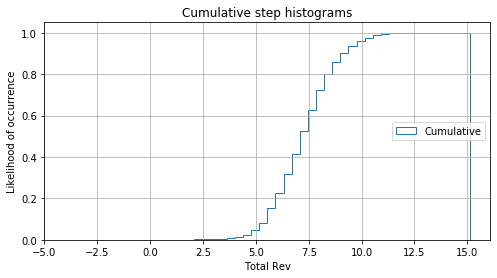

In [115]:
# checking outlier 
x= df_rev.loc[df_rev['ControlGroup']==1,'TotalRevenue'].apply(lambda x: math.log(x,2))

n_bins=50

fig,ax = plt.subplots(figsize=(8,4))

n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
                           cumulative=True, label='Cumulative')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Total Rev')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

# around 95% revenue below 10

In [116]:
P1=np.percentile(Control_Rev,95)
P2=np.percentile(Var_Rev,95)

In [117]:
print(P1)
print(P2)

990.0
985.9289999999996


In [118]:
scipy.stats.mannwhitneyu(Control_Rev[Control_Rev<P1],Var_Rev[Var_Rev<P2])
#p-value decreased, but still way above 0.05

MannwhitneyuResult(statistic=67274112442.0, pvalue=0.3534123116151376)

In [119]:
##what to input for continuous test:

df_Test2_Result.loc[1,'Rev']=sum(Control_Rev[Control_Rev<P1])
df_Test2_Result.loc[0,'Rev']=sum(Var_Rev[Var_Rev<P2])

df_Test2_Result.loc[1,'Rev_sq']=sum(Control_Rev[Control_Rev<P1]**2)
df_Test2_Result.loc[0,'Rev_sq']=sum(Var_Rev[Var_Rev<P2]**2)


In [120]:
df_Test2_Result

,SessionID,Bounced,SawProduct,AddedToCart,ReachedCheckout,Converted,Rev,Rev_sq
ControlGroup,,,,,,,,
0,3274220,650577,2376056,993032,492472,360415,8.115238e+07,3.185347e+10
1,3271927,650289,2375665,992024,492193,359459,8.094784e+07,3.183078e+10


In [121]:
dic_rev_95={}
for index in df_Test2_Result.index:
    if index!=1:
        df_each_group=df_Test2_Result

        result=z_test_calculator_continuous(df_each_group,'Converted','Rev','Rev_sq')
        dic_rev_95['ControlGroup'+str(index)+'95pct']= result  

In [122]:
dic_rev_95

{'ControlGroup095pct': (0.47406389900752965,
  -0.00013233259599520003,
  -0.029800443332703708)}

In [123]:
numerator='ReachedCheckout'
denominator='AddedToCart'

denominator_dailydata=df_Test2[(df_Test2[denominator]==1) & (df_Test2['testid']==2)].drop_duplicates(['SessionID', 'ControlGroup']).groupby(['Date','ControlGroup'])['SessionID'].count()
numerator_dailydata=df_Test2[(df_Test2[numerator]==1) & (df_Test2['testid']==2)].drop_duplicates(['SessionID', 'ControlGroup']).groupby(['Date','ControlGroup'])['SessionID'].count()
numerator_dailydata.name=numerator
denominator_dailydata.name=denominator

In [124]:
denominator_aggdailydata=denominator_dailydata.reset_index()
numerator_aggdailydata=numerator_dailydata.reset_index()

In [125]:
denominator_aggdailydata

,Date,ControlGroup,AddedToCart
0,2019-06-18,0,39313
1,2019-06-18,1,39337
2,2019-06-19,0,36942
3,2019-06-19,1,36575
4,2019-06-20,0,33301
5,2019-06-20,1,33811
6,2019-06-21,0,32760
7,2019-06-21,1,32999
8,2019-06-22,0,31338
9,2019-06-22,1,31589


In [126]:
denominator_aggdailydata[denominator]=denominator_aggdailydata.groupby('ControlGroup')[denominator].cumsum()
numerator_aggdailydata[numerator]=numerator_aggdailydata.groupby('ControlGroup')[numerator].cumsum()

In [127]:
numerator_aggdailydata

,Date,ControlGroup,ReachedCheckout
0,2019-06-18,0,19319
1,2019-06-18,1,19437
2,2019-06-19,0,37798
3,2019-06-19,1,37502
4,2019-06-20,0,54307
5,2019-06-20,1,54351
6,2019-06-21,0,70481
7,2019-06-21,1,70431
8,2019-06-22,0,85712
9,2019-06-22,1,85787


In [128]:
df_cumsum=pd.DataFrame()
for date in df_Test2.drop_duplicates('Date')['Date'].tolist():
    
    df=denominator_aggdailydata[denominator_aggdailydata['Date']==date].set_index('ControlGroup',drop=True)
    df=df.merge(numerator_aggdailydata[numerator_aggdailydata['Date']==date].set_index('ControlGroup',drop=True),on='Date',left_index=True,right_index=True)
    
    
    sig_result=z_test_calculator(df,denominator, numerator)
    df_cumsum.loc[date,'Sig_Level']=1-sig_result[0]
    df_cumsum.loc[date,'Lift']=sig_result[1]

In [129]:
df_cumsum

,Sig_Level,Lift
2019-07-11,0.603035,-0.000377
2019-07-09,0.839357,-0.001487
2019-06-26,0.690304,-0.001282
2019-06-24,0.825820,0.002796
2019-06-25,0.628048,0.000901
2019-07-12,0.623139,-0.000449
2019-06-27,0.795884,-0.002027
2019-07-10,0.649901,-0.000566
2019-06-28,0.769998,-0.001730
2019-06-18,0.775553,-0.005464


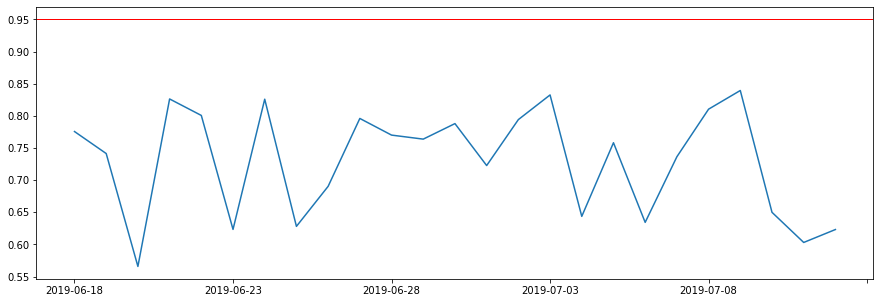

In [130]:
ax = df_cumsum.sort_index()['Sig_Level'].plot(figsize=(15,5))
ax.axhline(y=0.95,linewidth=1,color='r')